In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ct
import astropy.units as u

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
plt.style.use('./plotstyle.mplstyle')

In [3]:
def _sanders_winds(l, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l < l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
        
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [4]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [5]:
def _winds(log_l, y, z):
    l = 10.**log_l
    v01 = 1e-8
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [6]:
winds = np.vectorize(_winds)

In [7]:
ZSUN = 0.014

In [8]:
class HomogeneousStar:
    MLR_F = [
        4.025,
        4.277,
        -1.,
        25.48,
        36.93,
        -2.792,
        -3.226,
        -5.317,
        1.648
    ]
    
    LMR_F = [
     2.875,
     -3.966,
     2.496,
     2.652,
     -0.310,
     -0.511   
    ]
    
    LMR_PURE_HE_F =[
        3.017,
        2.446,
        -0.306
    ]
        
    def __init__(self, m0, x0, log_l_scale=1, timescale=4e6, z=0.014, dm=0.01, y0=0.4, dy=0.3,
                 surface_delay=0.9):
        self.m0 = m0
        self.log_l0 = self.get_log_l(np.log10(m0), x0)
        self.x0 = x0
        self.log_l_scale = log_l_scale
        self.timescale = timescale
        self.z = z
        self.dm = dm # timesteps are defined such that dm mass is lost
        self.y0 = y0
        self.dy = dy
        self.surface_delay = surface_delay
        self.core_fraction = 0.5
        self._t_ms = None
        
    @property
    def t_ms(self):
        if self._t_ms is None:
            self._t_ms = self.core_fraction * self.x0 * self.m0 * u.Msun / (10.**self.log_l0 * u.Lsun) * ct.c**2 * 0.007
            self._t_ms = self._t_ms.to(u.yr).value * (1+self.surface_delay/9)
        return self._t_ms
            
    def mdot(self, log_l, y, z):
        l = 10.**log_l
        v01 = 1e-8
        v17 = vink2017_winds(l, z)
        s23 = sanders_winds(l, z)
        he_w = max(v17, s23)
        if y < self.y0:
            y_weight = 0
        elif y < self.y0+self.dy:
            y_weight = (y - self.y0)/self.dy
        else:
            y_weight = 1
        w = y_weight * he_w + (1-y_weight) * v01
        return w
        
    def x_h_old(self, x_prev, log_l=None, t=None):
        if t is None:
            x = self.x0 + (log_l-self.log_l0)*self.log_l_scale
            if x < 0:
                x = 0
            elif x > 1:
                x = 1
            return x
        elif log_l is None:
            x = self.x0 + t/self.timescale
        else:
            t_x = self.x0 - t/self.timescale
            logl_x = self.x0 - (log_l-self.log_l0)*self.log_l_scale
            #print(x_prev, t_x, logl_x, [logl_x-x_prev, t_x-x_prev])
            
            x = [logl_x, t_x][np.argmin([logl_x-x_prev, t_x-x_prev])]
        return x
        
    def x_h(self, t):
        x = (self.x0 - t/self.t_ms) / self.surface_delay
        return x
        
    def _f(self, x_h, log_l):
        f = (self.MLR_L[3] 
             + self.MLR_L[4]*x_h 
             + self.MLR_L[5]*x_h*x_h 
             + (self.MLR_L[6] + self.MLR_L[7]*x_h)*log_l)
        return f
    
    def get_log_m(self, log_l, x_h):
        f = self._f(x_h, log_l)
        log_m = (self.MLR_L[0] 
                 + self.MLR_L[1]*x_h 
                 + self.MLR_L[2]*np.sqrt(f) / (1+ self.MLR_L[8]*x_h))
        return log_m
    
    def get_log_l(self, log_m, x_h):     
        if x_h >= 0.1:
            log_l = (
                self.LMR_F[0] + self.LMR_F[1]*x_h
                + (self.LMR_F[2] + self.LMR_F[3]*x_h) * log_m
                + (self.LMR_F[4] + self.LMR_F[5]*x_h) * log_m*log_m
            )
        else:
            log_l = (
                self.LMR_PURE_HE_F[0]
                + self.LMR_PURE_HE_F[1] * log_m
                + self.LMR_PURE_HE_F[2] * log_m*log_m
            )
            
        return log_l
    
    def _get_mdot(self, log_l, x_h):
        y = 1 - x_h - self.z
        mdot = self.mdot(log_l, y, self.z)
        return mdot
    
    def get_tams_m_logl_y(self):
        t = 0 # yr
        m = self.m0
        x = self.x0
        log_l = self.log_l0
        while x > 0:
            mdot = self._get_mdot(log_l, x)
            dt = self.dm/mdot
            m -= self.dm
            t += dt
            x = self.x_h(t)
            log_l = self.get_log_l(np.log10(m), x)
            
            #dlog_l = 1 
            #prev_log_l = log_l
            #new_x = x
            #counter = 0
            #while dlog_l > 1e-6 and counter < 10:
                #log_l = self.get_log_l(np.log10(m), new_x)
                #new_x = self.x_h(x, log_l, t)
                #dlog_l = np.abs(log_l - prev_log_l)
                #prev_log_l = log_l
                #if dlog_l < 0.1:
                #    counter += 1
            
            #if new_x < x:
            #    x = new_x              
                        
            #t += dt
        y = 1 - x - self.z
        return m, log_l, y
        

In [9]:
star = HomogeneousStar(50, 0.7, surface_delay=0.8, dm=0.001)

In [10]:
star.get_tams_m_logl_y()

(14.777000000023074, 5.459220817019204, 0.986013235288056)

In [11]:
def salpeter(m):
    return m**-2.3

In [12]:
size = 1000
pool = np.logspace(np.log10(30), np.log10(300), 100*size)
p = salpeter(pool)
p /= np.sum(p)
zams_masses = np.random.choice(pool, p=p, size=size)

In [13]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 1

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses1 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}=1\\mathrm{Z}_\\odot$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

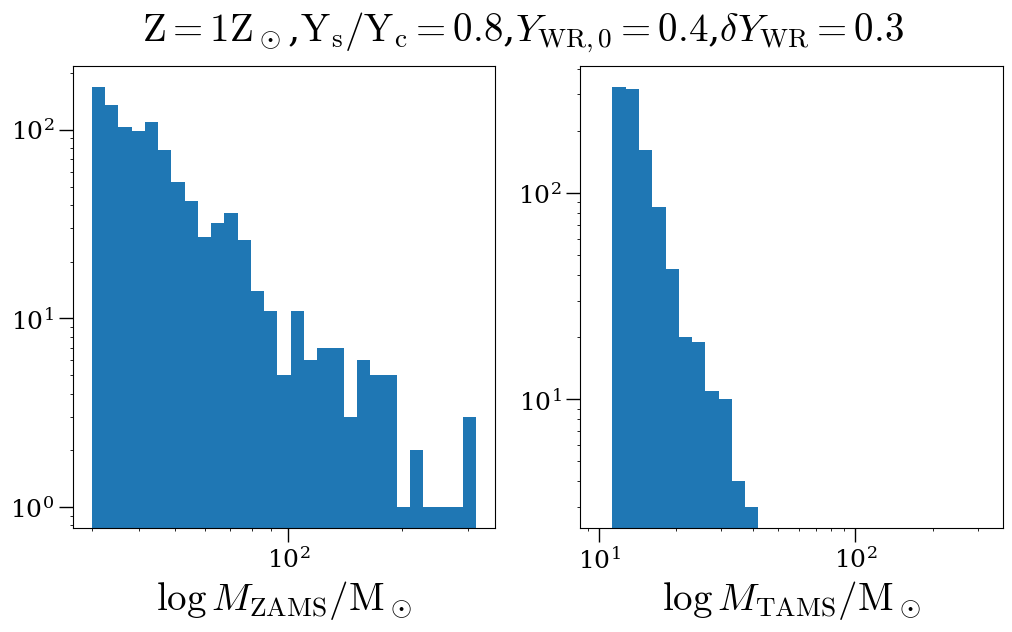

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
tams_masses = tams_masses1

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses, bins=np.logspace(1, 2.5, 30))
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}={z_zsun}\\mathrm{{Z}}_\\odot$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}={y0}$',
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

In [15]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.2

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses2 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}=0.2\\mathrm{Z}_\\odot$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

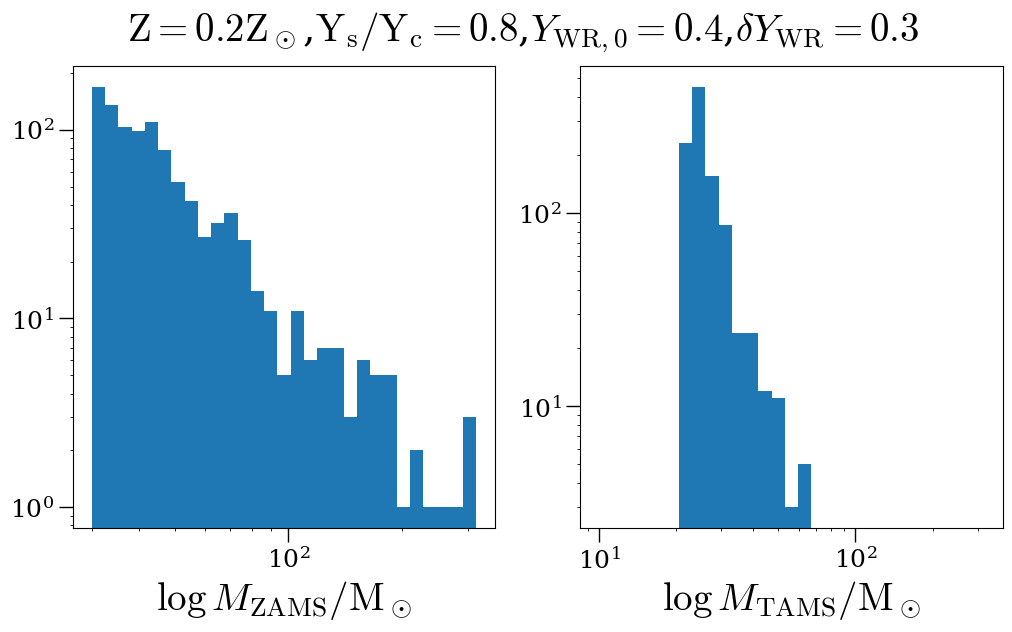

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
tams_masses = tams_masses

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses, bins=np.logspace(1, 2.5, 30))
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}={z_zsun}\\mathrm{{Z}}_\\odot$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}={y0}$',
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

In [17]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.1

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses3 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}=0.1\\mathrm{Z}_\\odot$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

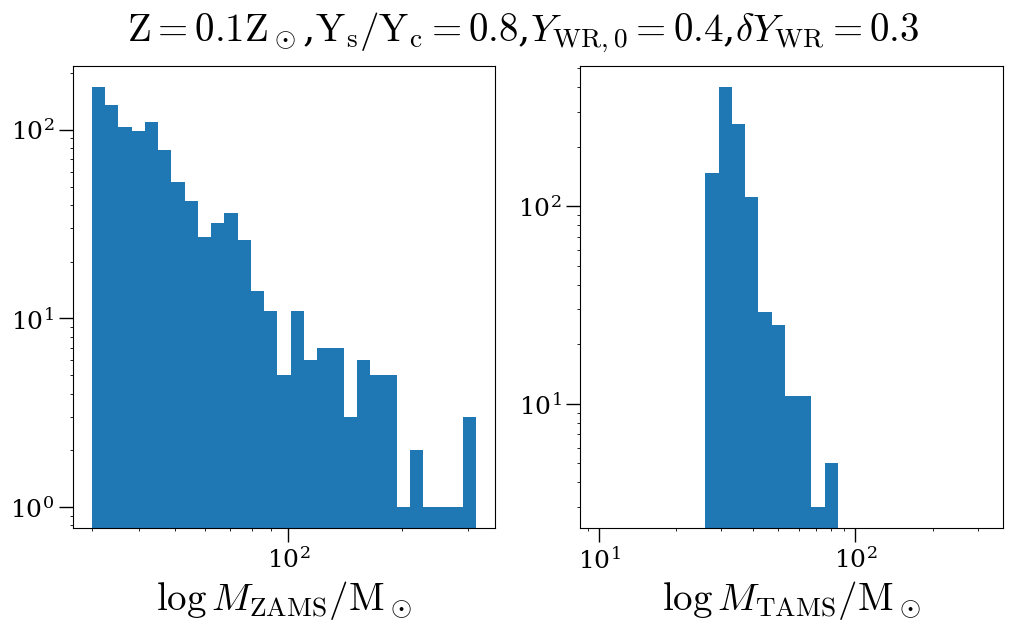

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
tams_masses = tams_masses3

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses, bins=np.logspace(1, 2.5, 30))
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}={z_zsun}\\mathrm{{Z}}_\\odot$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}={y0}$',
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

In [19]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.02

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses4 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}=0.02\\mathrm{Z}_\\odot$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

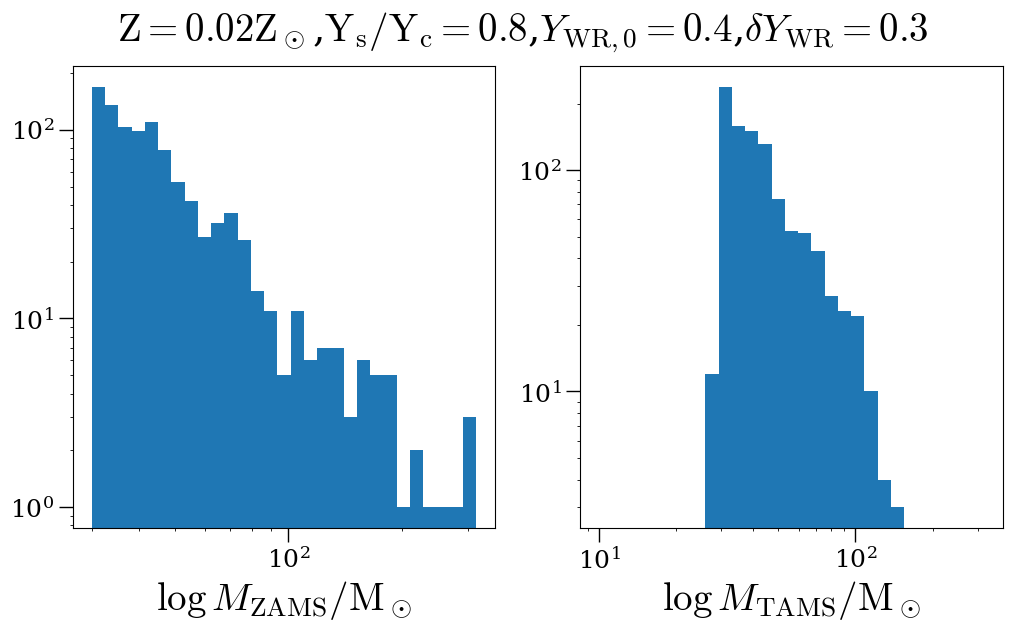

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
tams_masses = tams_masses4

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses, bins=np.logspace(1, 2.5, 30))
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}={z_zsun}\\mathrm{{Z}}_\\odot$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}={y0}$',
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

In [21]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses4 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}=0.05\\mathrm{Z}_\\odot$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

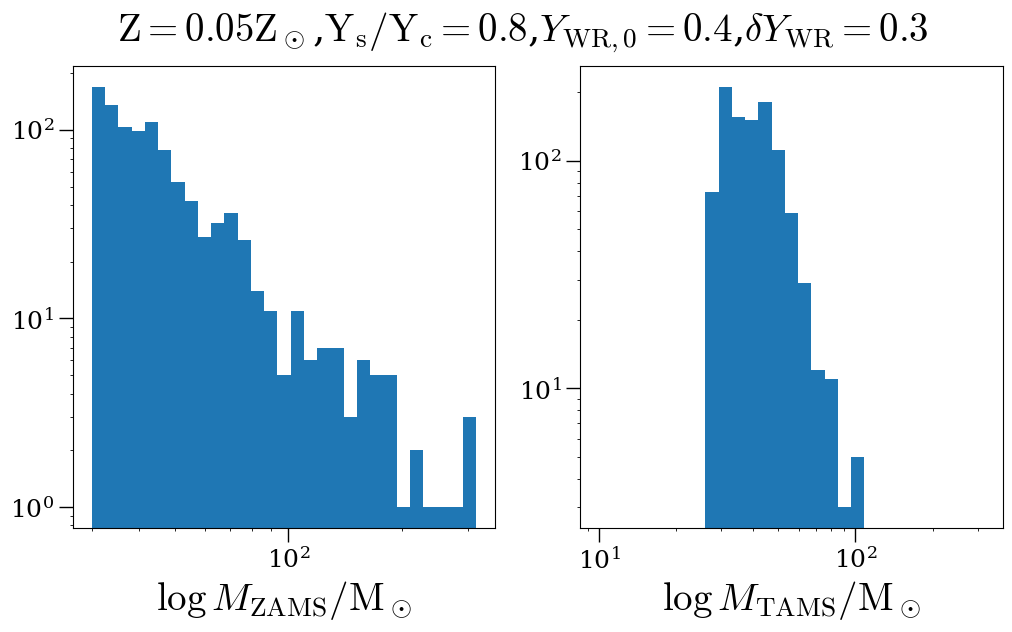

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
tams_masses = tams_masses4

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses, bins=np.logspace(1, 2.5, 30))
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}={z_zsun}\\mathrm{{Z}}_\\odot$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}={y0}$',
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

Text(0.5, 0.9, '$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

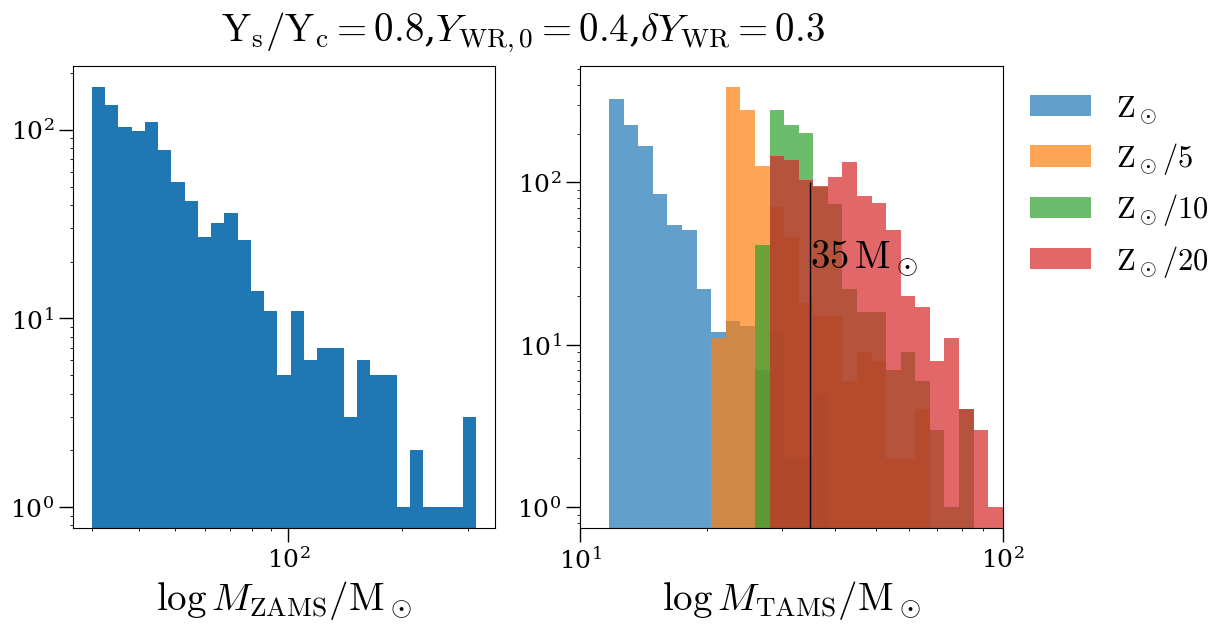

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses1, bins=np.logspace(1, 2, 30), alpha=0.7, label=f'$\\mathrm{{Z}}_\\odot$')
axes[1].hist(tams_masses2, bins=np.logspace(1, 2, 30), alpha=0.7, label=f'$\\mathrm{{Z}}_\\odot/5$')
axes[1].hist(tams_masses3, bins=np.logspace(1, 2, 30), alpha=0.7, label=f'$\\mathrm{{Z}}_\\odot/10$')
axes[1].hist(tams_masses4, bins=np.logspace(1, 2, 30), alpha=0.7, label=f'$\\mathrm{{Z}}_\\odot/20$')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')
axes[1].legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
axes[1].vlines(35, 0.1, 100, color='k', lw=1)
axes[1].set_xlim(10, 100)
axes[1].set_xticklabels([], minor=True)
axes[1].text(35, 30, '$35\\,\\mathrm{M}_\\odot$', transform=axes[1].transData)

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}={y0}$',
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

In [24]:
surface_delay = 0.8
y0 = 0.3
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_y0_03 = tams_masses


In [25]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_y0_04 = tams_masses


In [26]:
surface_delay = 0.8
y0 = 0.5
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_y0_05 = tams_masses


In [27]:
surface_delay = 0.8
y0 = 0.6
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_y0_06 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}_\\odot/20$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$\\delta Y_\\mathrm{WR}=0.3$')

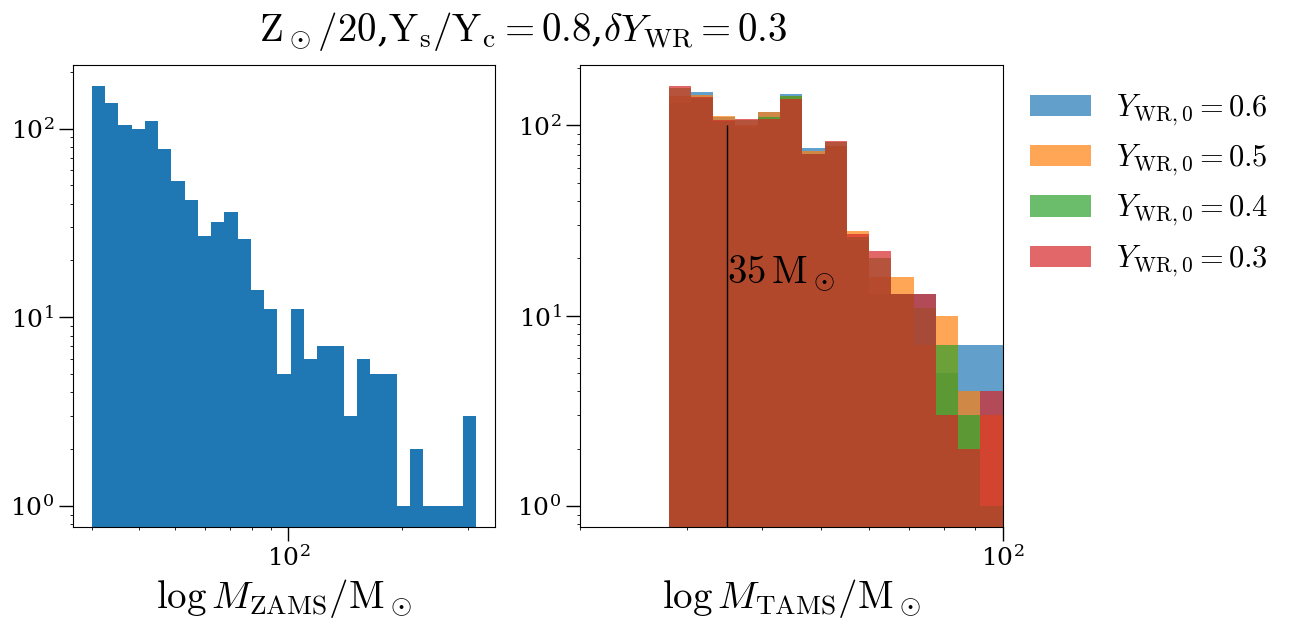

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses_y0_06, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.6$',)
axes[1].hist(tams_masses_y0_05, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.5$',)
axes[1].hist(tams_masses_y0_04, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.4$',)
axes[1].hist(tams_masses_y0_03, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.3$',)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')
axes[1].legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
axes[1].vlines(35, 0.1, 100, color='k', lw=1)
axes[1].set_xlim(20, 100)
axes[1].set_xticklabels([], minor=True)
axes[1].text(35, 15, '$35\\,\\mathrm{M}_\\odot$', transform=axes[1].transData)

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}_\\odot/20$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

Text(0.5, 0.9, '$\\mathrm{Z}_\\odot/20$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$\\delta Y_\\mathrm{WR}=0.3$')

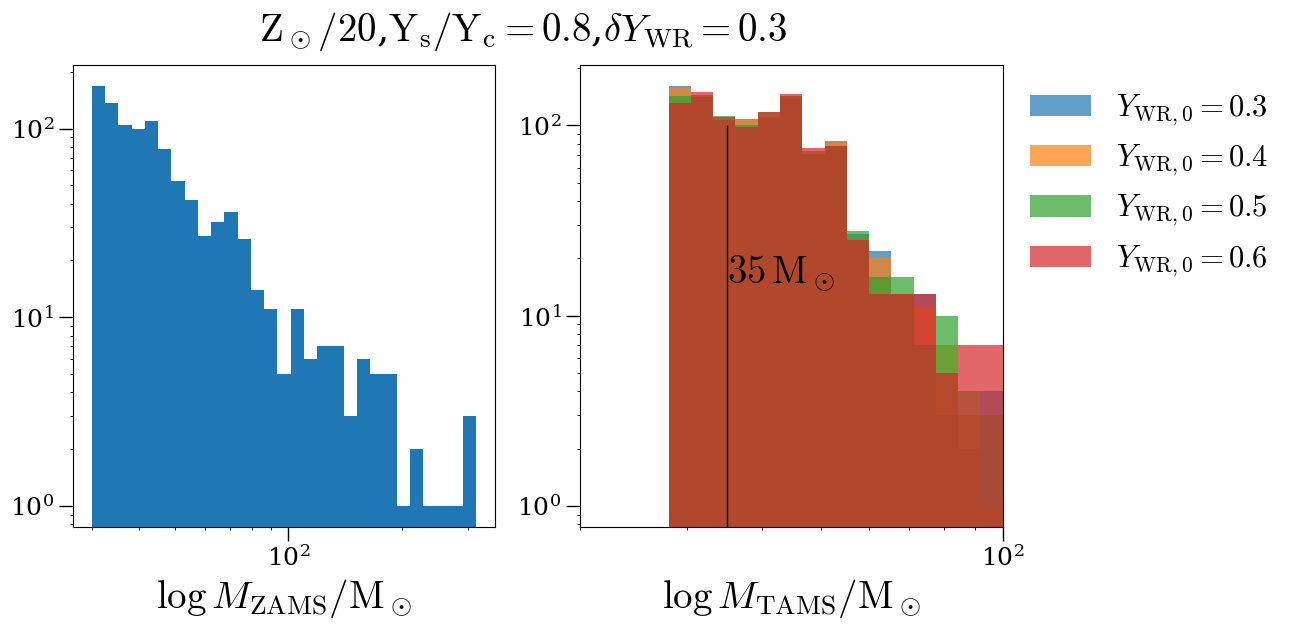

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses_y0_03, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.3$',)
axes[1].hist(tams_masses_y0_04, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.4$',)
axes[1].hist(tams_masses_y0_05, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.5$',)
axes[1].hist(tams_masses_y0_06, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$Y_{{\\mathrm{{WR}},0}}=0.6$',)


axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')
axes[1].legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
axes[1].vlines(35, 0.1, 100, color='k', lw=1)
axes[1].set_xlim(20, 100)
axes[1].set_xticklabels([], minor=True)
axes[1].text(35, 15, '$35\\,\\mathrm{M}_\\odot$', transform=axes[1].transData)

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}_\\odot/20$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$\\delta Y_\\mathrm{{WR}}={dy}$'
        )),
    ha='center',
    va='bottom'
)

In [30]:
surface_delay = 0.8
y0 = 0.4
dy = 0.2
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_dy_02 = tams_masses


In [31]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_dy_03 = tams_masses


In [ ]:
surface_delay = 0.8
y0 = 0.4
dy = 0.4
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_dy_04 = tams_masses


In [ ]:
surface_delay = 0.8
y0 = 0.4
dy = 0.5
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_dy_05 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}_\\odot/20$,$\\mathrm{Y}_\\mathrm{s}/\\mathrm{Y}_\\mathrm{c}=0.8$,$Y_{\\mathrm{WR},0}=0.4$')

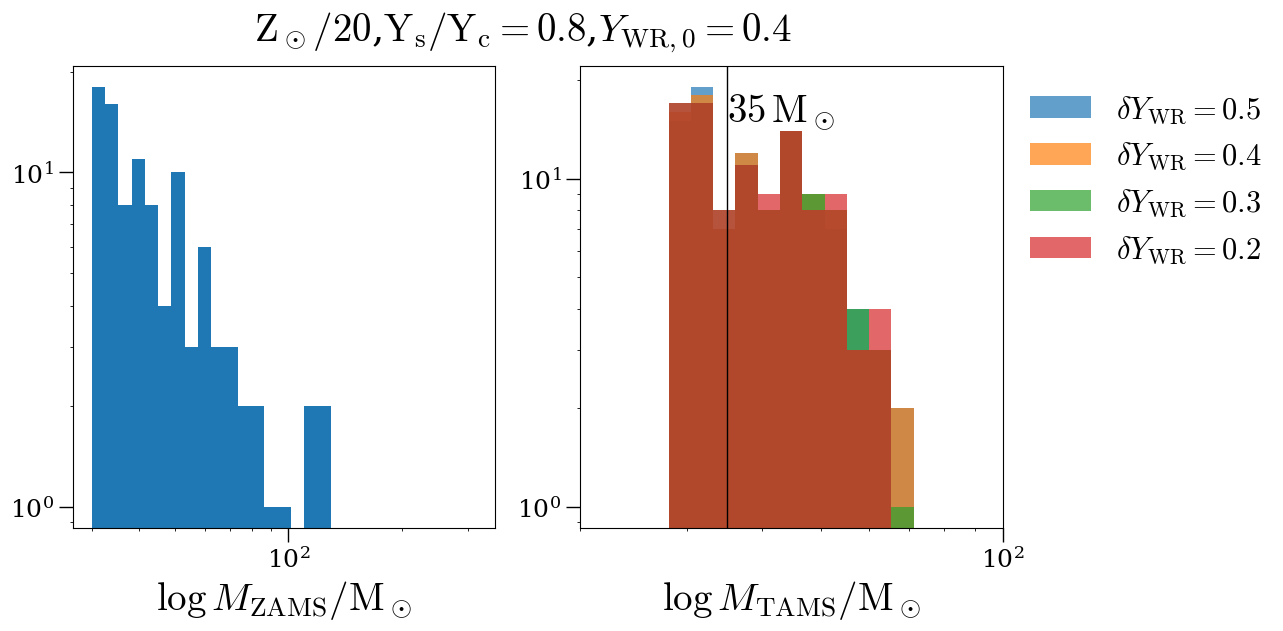

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses_dy_05, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\delta Y_\\mathrm{{WR}}=0.5$')
axes[1].hist(tams_masses_dy_04, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\delta Y_\\mathrm{{WR}}=0.4$')
axes[1].hist(tams_masses_dy_03, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\delta Y_\\mathrm{{WR}}=0.3$')
axes[1].hist(tams_masses_dy_02, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\delta Y_\\mathrm{{WR}}=0.2$')

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')
axes[1].legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
axes[1].vlines(35, 0.1, 100, color='k', lw=1)
axes[1].set_xlim(20, 100)
axes[1].set_xticklabels([], minor=True)
axes[1].text(35, 15, '$35\\,\\mathrm{M}_\\odot$', transform=axes[1].transData)

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}_\\odot/20$',
        f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}={surface_delay}$', 
        f'$Y_{{\\mathrm{{WR}},0}}=0.4$'
        )),
    ha='center',
    va='bottom'
)

In [ ]:
surface_delay = 0.8
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_sd_09 = tams_masses


In [ ]:
surface_delay = 0.6
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_sd_08 = tams_masses


In [ ]:
surface_delay = 0.4
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_sd_07 = tams_masses


In [ ]:
surface_delay = 0.2
y0 = 0.4
dy = 0.3
z_zsun = 0.05

tams_masses = []
for m in zams_masses:
    star = HomogeneousStar(m, x0=0.7, dm=0.001, z=z_zsun * ZSUN, y0=y0, dy=dy, surface_delay=surface_delay)
    tams_masses.append(star.get_tams_m_logl_y()[0])
tams_masses_sd_06 = tams_masses


Text(0.5, 0.9, '$\\mathrm{Z}_\\odot/20$,$Y_{\\mathrm{WR},0}=0.4$,$\\delta Y_\\mathrm{WR}=0.3$')

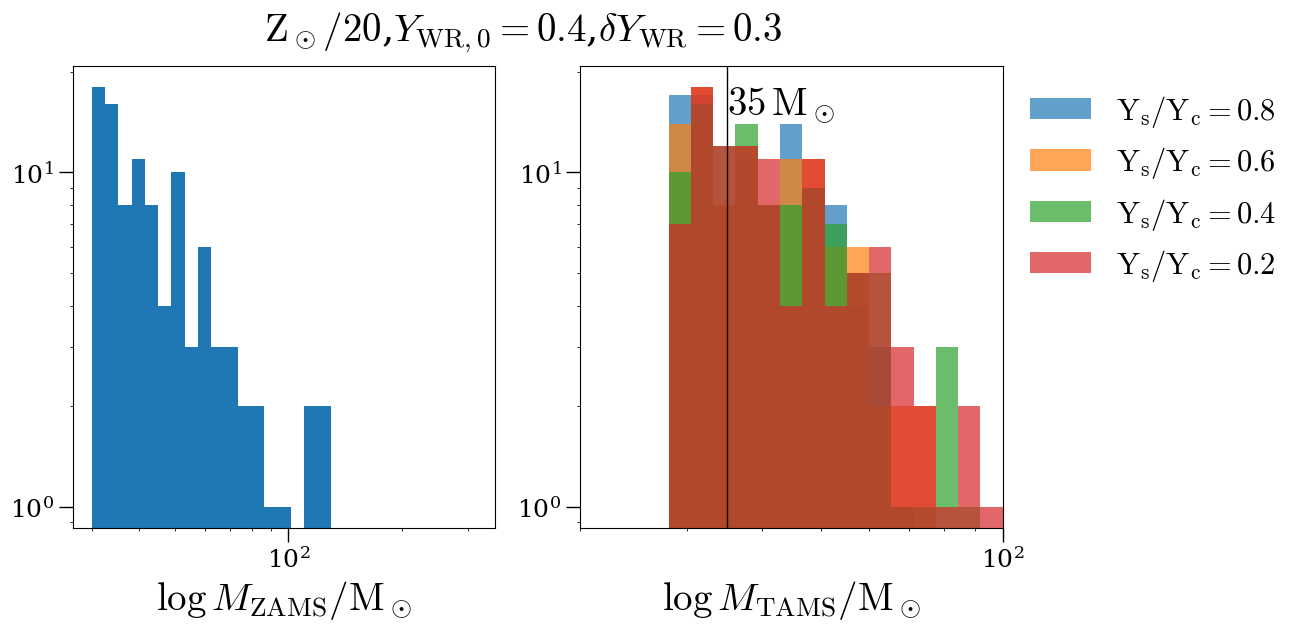

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(zams_masses, bins=np.logspace(np.log10(30), 2.5, 30))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

axes[1].hist(tams_masses_sd_09, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}=0.8$')
axes[1].hist(tams_masses_sd_08, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}=0.6$')
axes[1].hist(tams_masses_sd_07, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}=0.4$')
axes[1].hist(tams_masses_sd_06, bins=np.logspace(1.3, 2, 20), alpha=0.7, label=f'$\\mathrm{{Y}}_\\mathrm{{s}}/\\mathrm{{Y}}_\\mathrm{{c}}=0.2$')

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$\\log M_\\mathrm{TAMS}/\\mathrm{M}_\\odot$')
axes[1].legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
axes[1].vlines(35, 0.1, 100, color='k', lw=1)
axes[1].set_xlim(20, 100)
axes[1].set_xticklabels([], minor=True)
axes[1].text(35, 15, '$35\\,\\mathrm{M}_\\odot$', transform=axes[1].transData)

fig.text(
    0.5, 
    0.9, 
    ','.join((
        f'$\\mathrm{{Z}}_\\odot/20$',
        f'$Y_{{\\mathrm{{WR}},0}}=0.4$',
        f'$\\delta Y_\\mathrm{{WR}}=0.3$'
        )),
    ha='center',
    va='bottom'
)